#Wstęp

Dane zawierają informacje o posiadaczach kart kredytowych i ich zwyczajach wydawania pieniędzy. Dane pochodzą z pewnego banku w Tajwanie (30 000 obserwacji). Klienci należą do jednej z dwóch klas: wiarygodna i ryzykowna. 

Model ma na celu ocenę ryzyka niewypłacalności klienta na podstawie danych dostępnych w zbiorze (zarządzanie ryzykiem).

**Dane w zbiorze:**

X1: Kwota udzielonego kredytu\
X2: Płeć\
X3: Edukacja\
X4: Stan cywilny\
X5: Wiek\
X6-X11: Historia wcześniejszych płatności\
X12-X17: Kwoty wyciągu z rachunku\
X18-X23: Kwoty poprzedniej płatności

#Import bibliotek

In [362]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc
import numpy as np

In [ ]:
!pip install gdown

In [ ]:
from google.colab import files

!gdown --id 17fUO7NIeyn2WDDi6YRbirMYkiyBP-Q-R

#Zapoznanie ze zbiorem danych

In [243]:
#konwersja pliku xls do csv

def convert_xls_to_csv(input_file, output_file):
    data_frame = pd.read_excel(input_file)
    data_frame.to_csv(output_file, index=False)


input_file = 'default of credit card clients.xls'
output_file = 'clients.csv'

convert_xls_to_csv(input_file, output_file)

In [244]:
clients = pd.read_csv('clients.csv', skiprows=1)  #skiprows 1 poniewaz była nieczytelna (dodatkowa nazwa kolumny)

In [245]:
clients.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [246]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [247]:
clients.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [248]:
pd.set_option('display.max_columns', None)
clients.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [249]:
pd.set_option('display.max_columns', None)
clients.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [250]:
clients['default payment next month'].value_counts()  # niewypłacalność: 1 = Yes, 0 = No

0    23364
1     6636
Name: default payment next month, dtype: int64

In [251]:
clients['SEX'].value_counts()  #1 = male, 2 = female

2    18112
1    11888
Name: SEX, dtype: int64

In [252]:
clients['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [253]:
clients['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [254]:
print(clients["MARRIAGE"].unique())
print(clients["EDUCATION"].unique())
print(clients["LIMIT_BAL"].unique())

[1 2 3 0]
[2 1 3 5 4 6 0]
[  20000  120000   90000   50000  500000  100000  140000  200000  260000
  630000   70000  250000  320000  360000  180000  130000  450000   60000
  230000  160000  280000   10000   40000  210000  150000  380000  310000
  400000   80000  290000  340000  300000   30000  240000  470000  480000
  350000  330000  110000  420000  170000  370000  270000  220000  190000
  510000  460000  440000  410000  490000  390000  580000  600000  620000
  610000  700000  670000  680000  430000  550000  540000 1000000  530000
  710000  560000  520000  750000  640000   16000  570000  590000  660000
  720000  327680  740000  800000  760000  690000  650000  780000  730000]


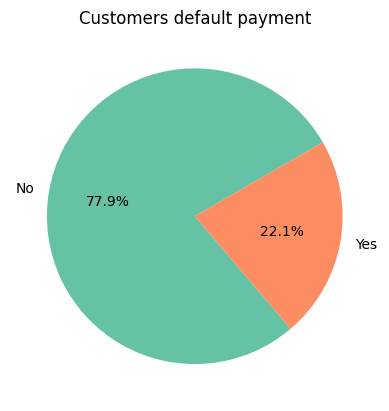

In [255]:
value_counts = clients['default payment next month'].value_counts()
plt.pie(value_counts.values, labels=['No', 'Yes'], autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=30)
plt.title('Customers default payment')
plt.show()

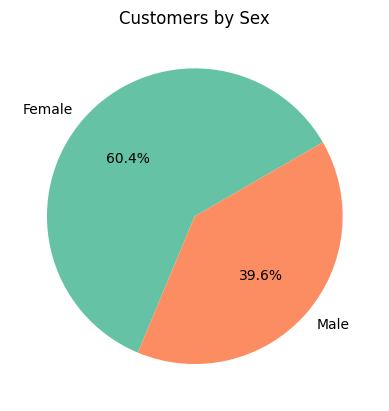

In [256]:
value_counts = clients['SEX'].value_counts()
plt.pie(value_counts.values, labels=['Female', 'Male'], autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=30)
plt.title('Customers by Sex')
plt.show()

<ipython-input-257-7ffc08de1eec>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clients.AGE)


<Axes: xlabel='AGE', ylabel='Density'>

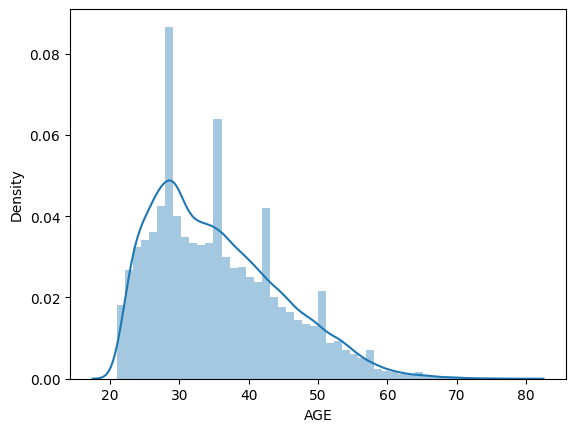

In [257]:
sns.distplot(clients.AGE)

<ipython-input-258-d79c14e66361>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clients.LIMIT_BAL)


<Axes: xlabel='LIMIT_BAL', ylabel='Density'>

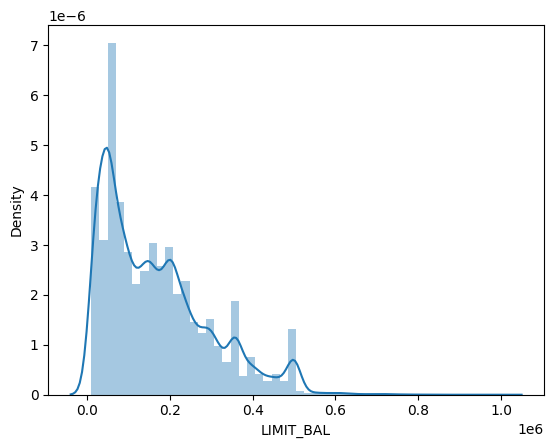

In [258]:
sns.distplot(clients.LIMIT_BAL)

In [259]:
clients=clients.drop(['ID'], axis=1)  #usuwamy kolumnę ID

In [260]:
clients.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


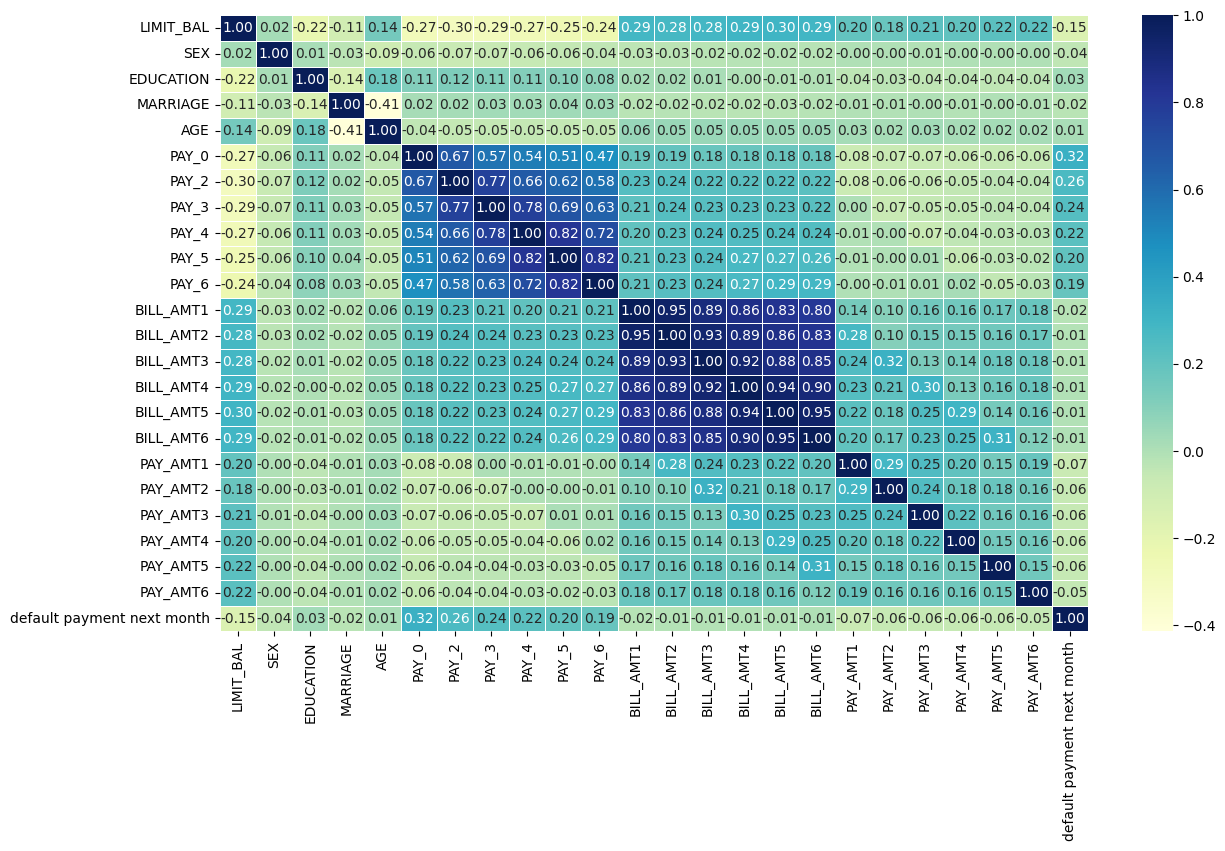

In [261]:
#Heatmap
fig,ax = plt.subplots(figsize=(14, 8))
sns.heatmap(clients.corr(), annot=True, linewidths=.5, fmt= '.2f', cmap="YlGnBu")
plt.show()

In [262]:
# Podział X i y
y = clients.pop('default payment next month')
X = clients

In [263]:
# Podział na zbiór testowy i treningowy
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.20, random_state=123)

In [264]:
#sprawdzanie ilości 0 i 1 w danych treningowych i testowych
Counter(y_train)

Counter({0: 18668, 1: 5332})

In [265]:
Counter(y_test)

Counter({0: 4696, 1: 1304})

#Modele predykcyjne

##SVM

In [266]:
svm=SVC(kernel='poly', class_weight='balanced')
svm.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='poly')

In [267]:
y_pred_svc = svm.predict(X_test)

In [268]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.92      0.16      0.27      4696
           1       0.24      0.95      0.38      1304

    accuracy                           0.33      6000
   macro avg       0.58      0.55      0.32      6000
weighted avg       0.77      0.33      0.29      6000



<Axes: >

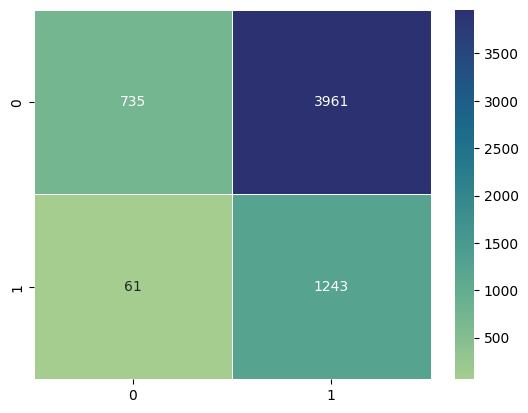

In [269]:
cm=confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Regresja logistyczna

In [270]:
log_model=LogisticRegression(class_weight='balanced')
log_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [271]:
y_pred_lr = log_model.predict(X_test)

In [272]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.86      0.60      0.71      4696
           1       0.31      0.64      0.41      1304

    accuracy                           0.61      6000
   macro avg       0.58      0.62      0.56      6000
weighted avg       0.74      0.61      0.64      6000



<Axes: >

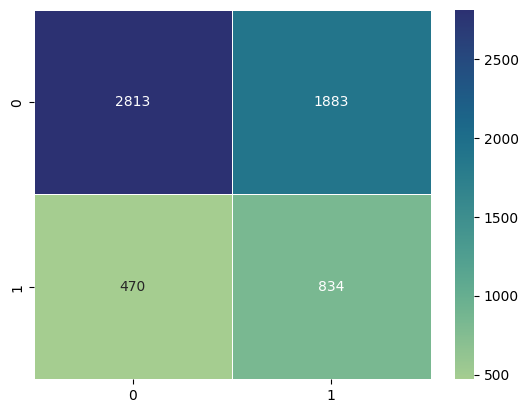

In [273]:
cm=confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Drzewo decyzyjne

In [274]:
dt = DecisionTreeClassifier(criterion='log_loss', class_weight='balanced')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='log_loss')

In [275]:
y_pred_dt = dt.predict(X_test)

In [276]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      4696
           1       0.40      0.42      0.41      1304

    accuracy                           0.73      6000
   macro avg       0.62      0.62      0.62      6000
weighted avg       0.74      0.73      0.74      6000



<Axes: >

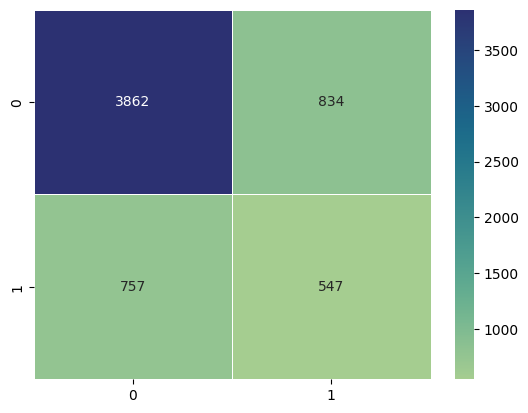

In [277]:
cm=confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Random Forest

In [278]:
rf_model=RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [279]:
y_pred_rf = rf_model.predict(X_test)

In [280]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4696
           1       0.64      0.36      0.46      1304

    accuracy                           0.82      6000
   macro avg       0.74      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



<Axes: >

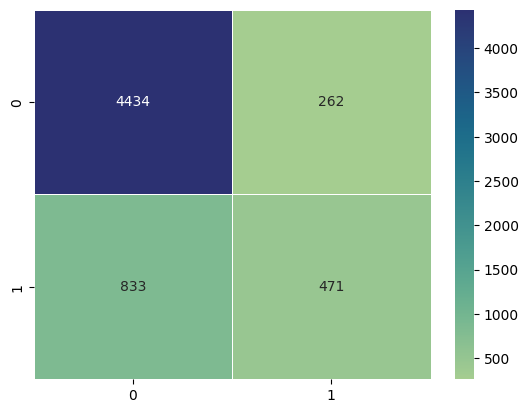

In [281]:
cm=confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Boosting: AdaBoost

In [282]:
ab_model = AdaBoostClassifier()
ab_model.fit(X_train, y_train)

AdaBoostClassifier()

In [283]:
y_pred_ab = ab_model.predict(X_test)

In [284]:
print(classification_report(y_test, y_pred_ab))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4696
           1       0.68      0.33      0.44      1304

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000



<Axes: >

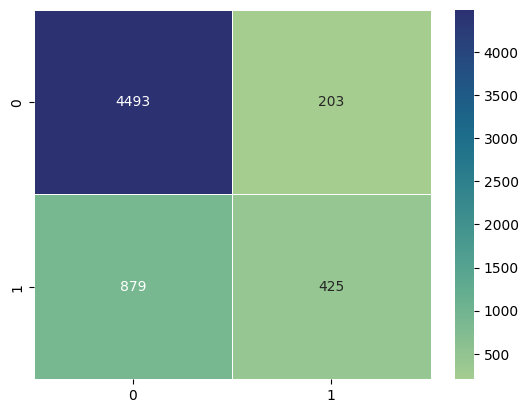

In [285]:
cm=confusion_matrix(y_test, y_pred_ab)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

#Standaryzacja danych

In [286]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [287]:
X

array([[-1.13672015,  0.81016074,  0.18582826, ..., -0.30806256,
        -0.31413612, -0.29338206],
       [-0.3659805 ,  0.81016074,  0.18582826, ..., -0.24422965,
        -0.31413612, -0.18087821],
       [-0.59720239,  0.81016074,  0.18582826, ..., -0.24422965,
        -0.24868274, -0.01212243],
       ...,
       [-1.05964618, -1.23432296,  0.18582826, ..., -0.03996431,
        -0.18322937, -0.11900109],
       [-0.67427636, -1.23432296,  1.45111372, ..., -0.18512036,
         3.15253642, -0.19190359],
       [-0.90549825, -1.23432296,  0.18582826, ..., -0.24422965,
        -0.24868274, -0.23713013]])

#Modele predykcyjne + Oversampling

In [288]:
# Zastosowanie oversamplingu na danych treningowych (dane niezbalansowane)
oversampler = RandomOverSampler()
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

In [289]:
Counter(y_train_over)

Counter({0: 18668, 1: 18668})

##SVM

In [291]:
svm=SVC(kernel='poly')
svm.fit(X_train_over, y_train_over)

SVC(kernel='poly')

In [292]:
y_pred_svc = svm.predict(X_test)

In [293]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.92      0.17      0.28      4696
           1       0.24      0.95      0.38      1304

    accuracy                           0.34      6000
   macro avg       0.58      0.56      0.33      6000
weighted avg       0.77      0.34      0.30      6000



<Axes: >

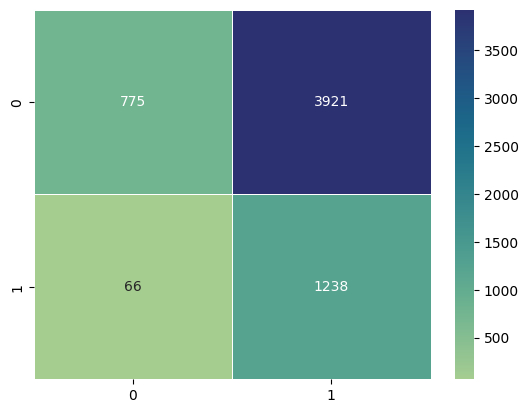

In [294]:
cm=confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Regresja logistyczna

In [295]:
log_model=LogisticRegression()
log_model.fit(X_train_over, y_train_over)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [296]:
y_pred_lr = log_model.predict(X_test)

In [297]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.87      0.54      0.66      4696
           1       0.30      0.71      0.42      1304

    accuracy                           0.57      6000
   macro avg       0.58      0.62      0.54      6000
weighted avg       0.74      0.57      0.61      6000



<Axes: >

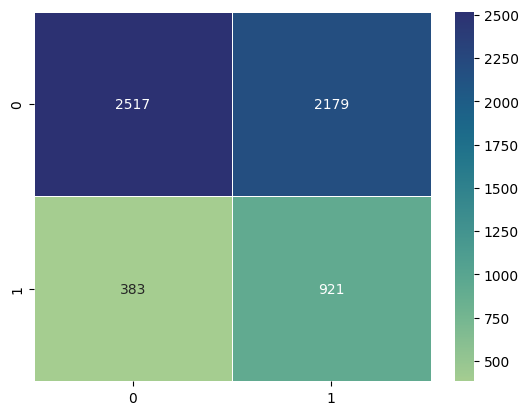

In [298]:
cm=confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Drzewo decyzyjne

In [299]:
dt = DecisionTreeClassifier(criterion='log_loss')
dt.fit(X_train_over, y_train_over)

DecisionTreeClassifier(criterion='log_loss')

In [300]:
y_pred_dt = dt.predict(X_test)

In [301]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      4696
           1       0.38      0.40      0.39      1304

    accuracy                           0.73      6000
   macro avg       0.60      0.61      0.61      6000
weighted avg       0.73      0.73      0.73      6000



<Axes: >

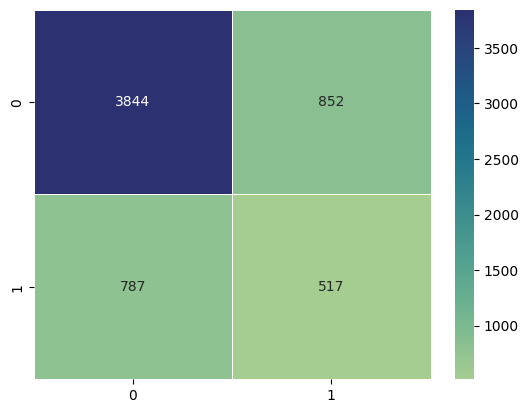

In [302]:
cm=confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Random Forest

In [303]:
rf_model=RandomForestClassifier()
rf_model.fit(X_train_over, y_train_over)

RandomForestClassifier()

In [304]:
y_pred_rf = rf_model.predict(X_test)

In [305]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4696
           1       0.58      0.46      0.51      1304

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.70      6000
weighted avg       0.80      0.81      0.80      6000



<Axes: >

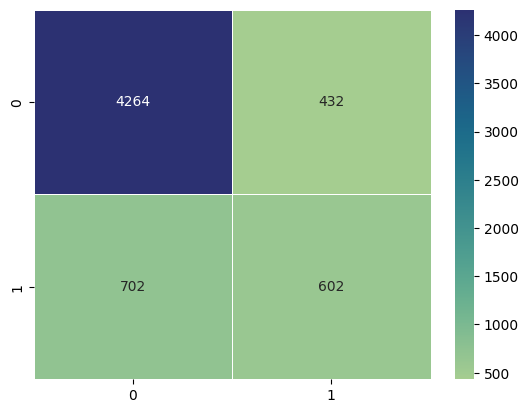

In [306]:
cm=confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Boosting: AdaBoost

In [307]:
ab_model = AdaBoostClassifier()
ab_model.fit(X_train_over, y_train_over)

AdaBoostClassifier()

In [308]:
y_pred_ab = ab_model.predict(X_test)

In [309]:
print(classification_report(y_test, y_pred_ab))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4696
           1       0.46      0.61      0.52      1304

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.79      0.76      0.77      6000



<Axes: >

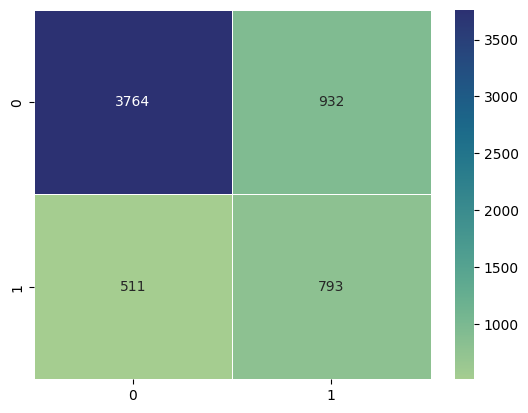

In [310]:
cm=confusion_matrix(y_test, y_pred_ab)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

# Modele predykcyjne + Undersampling

In [311]:
oversampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = oversampler.fit_resample(X_train, y_train)

In [355]:
Counter(y_train_under)

Counter({0: 5332, 1: 5332})

##SVM

In [312]:
svm=SVC(kernel='poly')
svm.fit(X_train_under, y_train_under)

SVC(kernel='poly')

In [313]:
y_pred_svc = svm.predict(X_test)

In [314]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.92      0.15      0.26      4696
           1       0.24      0.95      0.38      1304

    accuracy                           0.33      6000
   macro avg       0.58      0.55      0.32      6000
weighted avg       0.78      0.33      0.29      6000



<Axes: >

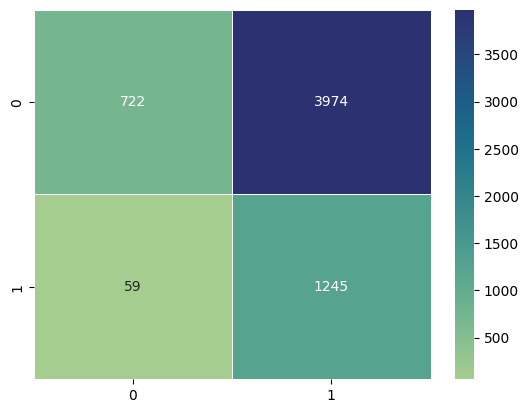

In [315]:
cm=confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Regresja logistyczna

In [316]:
log_model=LogisticRegression()
log_model.fit(X_train_under, y_train_under)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [317]:
y_pred_lr = log_model.predict(X_test)

In [318]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.87      0.49      0.63      4696
           1       0.29      0.74      0.41      1304

    accuracy                           0.54      6000
   macro avg       0.58      0.61      0.52      6000
weighted avg       0.74      0.54      0.58      6000



<Axes: >

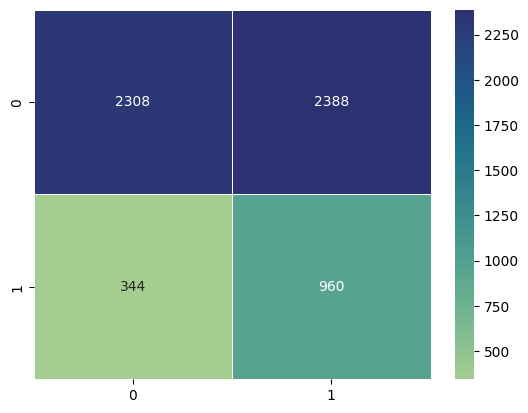

In [319]:
cm=confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Drzewo decyzyjne

In [320]:
dt = DecisionTreeClassifier(criterion='log_loss')
dt.fit(X_train_under, y_train_under)

DecisionTreeClassifier(criterion='log_loss')

In [321]:
y_pred_dt = dt.predict(X_test)

In [322]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.86      0.61      0.72      4696
           1       0.31      0.63      0.42      1304

    accuracy                           0.62      6000
   macro avg       0.58      0.62      0.57      6000
weighted avg       0.74      0.62      0.65      6000



<Axes: >

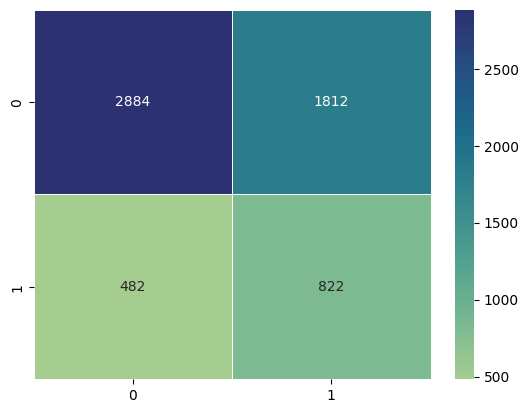

In [323]:
cm=confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Random Forest

In [324]:
rf_model=RandomForestClassifier()
rf_model.fit(X_train_under, y_train_under)

RandomForestClassifier()

In [325]:
y_pred_rf = rf_model.predict(X_test)

In [326]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      4696
           1       0.43      0.65      0.52      1304

    accuracy                           0.74      6000
   macro avg       0.66      0.71      0.67      6000
weighted avg       0.79      0.74      0.76      6000



<Axes: >

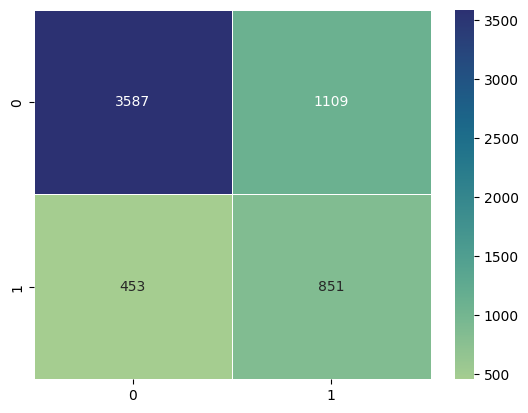

In [327]:
cm=confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Boosting: AdaBoost

In [328]:
ab_model = AdaBoostClassifier()
ab_model.fit(X_train_under, y_train_under)

AdaBoostClassifier()

In [329]:
y_pred_ab = ab_model.predict(X_test)

In [330]:
print(classification_report(y_test, y_pred_ab))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      4696
           1       0.44      0.62      0.52      1304

    accuracy                           0.75      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.79      0.75      0.76      6000



<Axes: >

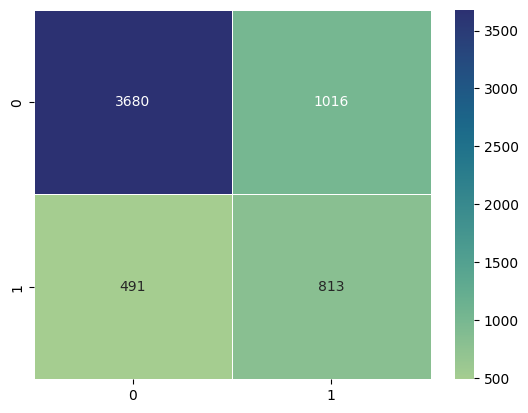

In [331]:
cm=confusion_matrix(y_test, y_pred_ab)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

#Modele predykcyjne + SMOTE

In [332]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [356]:
Counter(y_train_smote)

Counter({0: 18668, 1: 18668})

##SVM

In [333]:
svm=SVC(kernel='poly')
svm.fit(X_train_smote, y_train_smote)

SVC(kernel='poly')

In [334]:
y_pred_svc = svm.predict(X_test)

In [335]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.92      0.18      0.30      4696
           1       0.24      0.95      0.39      1304

    accuracy                           0.34      6000
   macro avg       0.58      0.56      0.34      6000
weighted avg       0.77      0.34      0.32      6000



<Axes: >

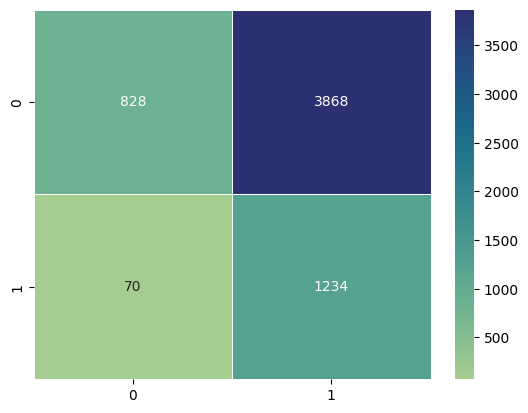

In [336]:
cm=confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Regresja logistyczna

In [337]:
log_model=LogisticRegression()
log_model.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [338]:
y_pred_lr = log_model.predict(X_test)

In [339]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      4696
           1       0.31      0.39      0.35      1304

    accuracy                           0.68      6000
   macro avg       0.57      0.58      0.57      6000
weighted avg       0.71      0.68      0.69      6000



<Axes: >

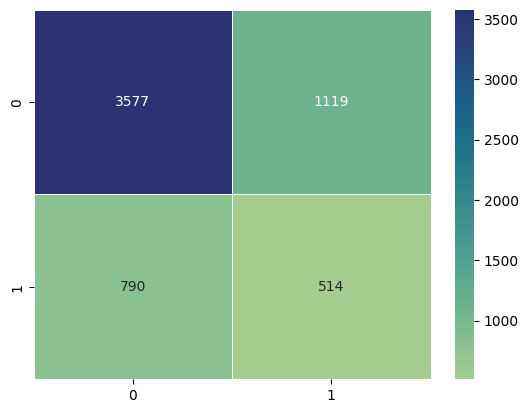

In [340]:
cm=confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Drzewo decyzyjne

In [341]:
dt = DecisionTreeClassifier(criterion='log_loss')
dt.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(criterion='log_loss')

In [342]:
y_pred_dt = dt.predict(X_test)

In [343]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      4696
           1       0.35      0.49      0.41      1304

    accuracy                           0.69      6000
   macro avg       0.59      0.62      0.60      6000
weighted avg       0.73      0.69      0.71      6000



<Axes: >

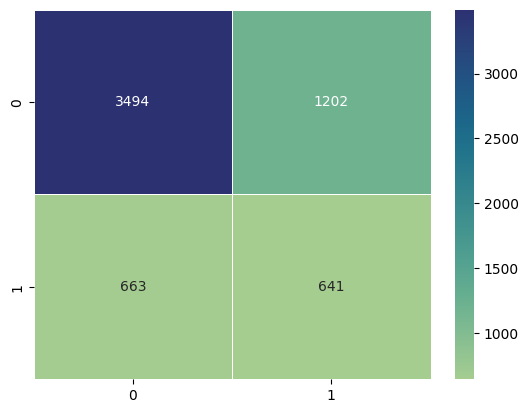

In [344]:
cm=confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Random Forest

In [370]:
rf_model=RandomForestClassifier()
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [371]:
y_pred_rf = rf_model.predict(X_test)

In [372]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4696
           1       0.62      0.38      0.47      1304

    accuracy                           0.82      6000
   macro avg       0.73      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



<Axes: >

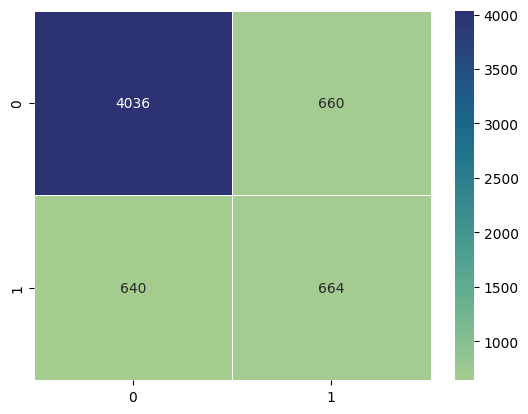

In [348]:
cm=confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

##Boosting: AdaBoost

In [349]:
ab_model = AdaBoostClassifier()
ab_model.fit(X_train_smote, y_train_smote)

AdaBoostClassifier()

In [350]:
y_pred_ab = ab_model.predict(X_test)

In [351]:
print(classification_report(y_test, y_pred_ab))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      4696
           1       0.41      0.60      0.49      1304

    accuracy                           0.73      6000
   macro avg       0.64      0.68      0.65      6000
weighted avg       0.77      0.73      0.74      6000



<Axes: >

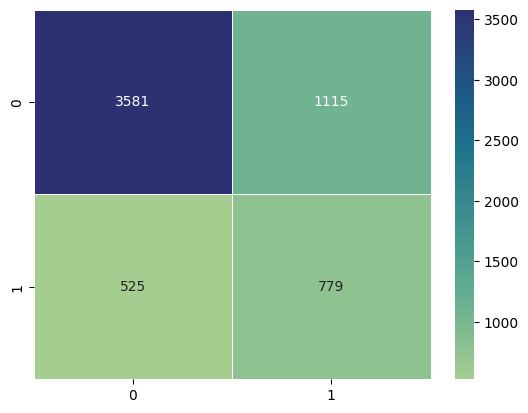

In [352]:
cm=confusion_matrix(y_test, y_pred_ab)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest", linewidth=.5)

#Feature Importance

Cecha 0: 0.059611366969935325
Cecha 1: 0.02873091257742499
Cecha 2: 0.02445525684563168
Cecha 3: 0.03227304959336836
Cecha 4: 0.054393873817420196
Cecha 5: 0.07583746285517869
Cecha 6: 0.056909700587205195
Cecha 7: 0.03784240894304477
Cecha 8: 0.02309592065632846
Cecha 9: 0.023027383976398426
Cecha 10: 0.019864136108882657
Cecha 11: 0.0592101948028363
Cecha 12: 0.04838532146637635
Cecha 13: 0.045252430282957244
Cecha 14: 0.04373178989761038
Cecha 15: 0.04363976086398184
Cecha 16: 0.043496587521138844
Cecha 17: 0.054806177260819884
Cecha 18: 0.051015031872752824
Cecha 19: 0.045862889931407816
Cecha 20: 0.04260579647335475
Cecha 21: 0.041215502896493256
Cecha 22: 0.04473704379945193


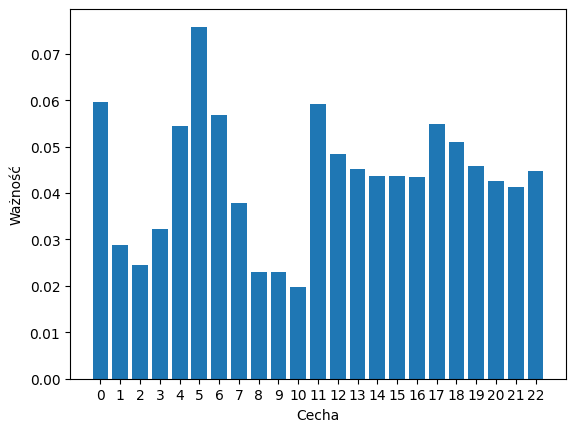

In [364]:
feature_importances = rf_model.feature_importances_  #na podstawie Random Forest

# Wyświetlenie ważności cech
for i, importance in enumerate(feature_importances):
    print(f"Cecha {i}: {importance}")

# Wykres ważności cech
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Cecha')
plt.ylabel('Ważność')
plt.xticks(ticks=np.arange(0, 23))
plt.show()

#ROC

In [353]:
fpr_svc, tpr_svc, _=roc_curve(y_test, y_pred_svc)
fpr_lr, tpr_lr, _=roc_curve(y_test, y_pred_lr)
fpr_dt, tpr_dt, _=roc_curve(y_test, y_pred_dt)
fpr_rf, tpr_rf, _=roc_curve(y_test, y_pred_rf)
fpr_ab, tpr_ab, _=roc_curve(y_test, y_pred_ab)

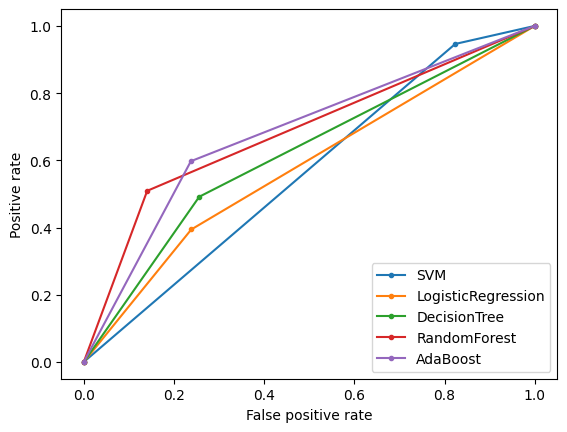

In [354]:
plt.plot(fpr_svc, tpr_svc, marker='.', label='SVM')
plt.plot(fpr_lr, tpr_lr, marker='.', label='LogisticRegression')
plt.plot(fpr_dt, tpr_dt, marker='.', label='DecisionTree')
plt.plot(fpr_rf, tpr_rf, marker='.', label='RandomForest')
plt.plot(fpr_ab, tpr_ab, marker='.', label='AdaBoost')
plt.xlabel('False positive rate')
plt.ylabel('Positive rate')
plt.legend(loc='lower right')
plt.show()

#Wnioski

Spośród zastosowanych modeli najlepiej poradziły sobie Random Forest oraz AdaBoost. Zastosowanie metod over/under samplingu oraz SMOTE nie poprawiło uzyskanych wyników. Selekcja cech na podstawie *feature importance* również nie poprawiała uzyskanych wyników. 

**Najlepszy wynik:**

Random Forest (dane oryginalne)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4696
           1       0.64      0.36      0.46      1304

    accuracy                           0.82      6000
